<a href="https://colab.research.google.com/github/PamudithaSomarathne/EN2550/blob/master/4%20Neural%20Network/EN2550_Assignment_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and prepare the dataset

In [8]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

import time

In [35]:
# Download and categorize data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
K = len(np.unique(y_train))

# Compute data parameters
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = x_train[0].size

# Normalize pixel values
x_train, x_test = x_train/255.0, x_test/255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert labels from integers to binary
y_train = keras.utils.to_categorical(y_train, num_classes=K)
y_test = keras.utils.to_categorical(y_test, num_classes=K)

# Reshape data and convert to float32                       # Wasn't them converted when normalizing???
x_train = x_train.reshape((Ntr,Din)).astype(np.float32)
x_test = x_test.reshape((Nte,Din)).astype(np.float32)

class_labels = ["airplane", "automobile", "bird", "cat", "deer", 
                "dog", "frog", "horse", "ship", "truck"]

print("Training data size :", x_train.shape, "\nTraining label size :",\
      y_train.shape, "\nTest data size :", x_test.shape, "\nTest label size :",\
      y_test.shape)
print("No of classes :", K)

Training data size : (50000, 3072) 
Training label size : (50000, 10) 
Test data size : (10000, 3072) 
Test label size : (10000, 10)
No of classes : 10


# Part 1: Linear classifier

In [5]:
def initialize_linear_weights(shape, epsilon=0.001):
  W = np.random.randn(shape[0], shape[1])*epsilon
  b = np.zeros((1,shape[1]))
  return [W,b]

def forward_prop_linear(x_data, weights):
  return np.matmul(x_data, weights[0]) +\
    np.matmul(np.ones((x_data.shape[0],1)),weights[1])

def mean_sum_of_squared_errors(y, y_hat):
  diff = (y-y_hat).astype(np.float32)
  return np.mean(np.sum(np.multiply(diff,diff),axis=1))

def back_prop_linear(y_hat, y, x):
  return [np.matmul(x.T,2*(y_hat-y))/x.shape[0],np.sum(2*(y_hat-y),axis=0)/x.shape[0]]

def gradient_descent_linear(grads, weights, learning_rate=0.01):
  weights[0] = weights[0]-learning_rate*grads[0]
  weights[1] = weights[1]-learning_rate*grads[1]
  return weights

In [9]:
no_epochs = 300
weights_linear = initialize_linear_weights((x_train.shape[1],K))
history_linear = []
learning_rate_linear = 0.017

tik = time.time()

print("Starting training of linear model for", no_epochs, "epochs")
for epo in range(1,no_epochs+1):
  y_hat = forward_prop_linear(x_train,weights_linear)
  loss = mean_sum_of_squared_errors(y_train, y_hat)
  grads = back_prop_linear(y_hat, y_train, x_train)
  weights = gradient_descent_linear(grads, weights_linear, learning_rate_linear)
  history_linear.append(loss)
  if not(epo%20): print("Epoch no.", epo, "| Training loss:",loss)

tok = time.time()
etime = tok-tik
print("Training complete.",int(etime//60),"minutes and", int(etime%60),
      "seconds elapsed.")

Starting training for 300 epochs
Epoch no. 20 | Training loss: 0.8354045
Epoch no. 40 | Training loss: 0.806563
Epoch no. 60 | Training loss: 0.79705
Epoch no. 80 | Training loss: 0.79275405
Epoch no. 100 | Training loss: 0.7901572
Epoch no. 120 | Training loss: 0.78827685
Epoch no. 140 | Training loss: 0.78678924
Epoch no. 160 | Training loss: 0.7855583
Epoch no. 180 | Training loss: 0.78451174
Epoch no. 200 | Training loss: 0.7836047
Epoch no. 220 | Training loss: 0.7828063
Epoch no. 240 | Training loss: 0.7820941
Epoch no. 260 | Training loss: 0.78145224
Epoch no. 280 | Training loss: 0.7808681
Epoch no. 300 | Training loss: 0.7803325
Training complete. 14.0 minutes and 30.905941486358643 seconds elapsed


In [48]:
def get_accuracy(y_hat, y):
  y_hat_bin = np.argmax(y_hat,axis=1)
  y_class = np.argmax(y,axis=1)
  return 100*np.sum(y_hat_bin==y_class)/y_class.size

Learning rate: 0.017
Training set final mean loss: 0.7803325
Test set mean loss: 0.78645545
Accuracy for test set: 40.55 %



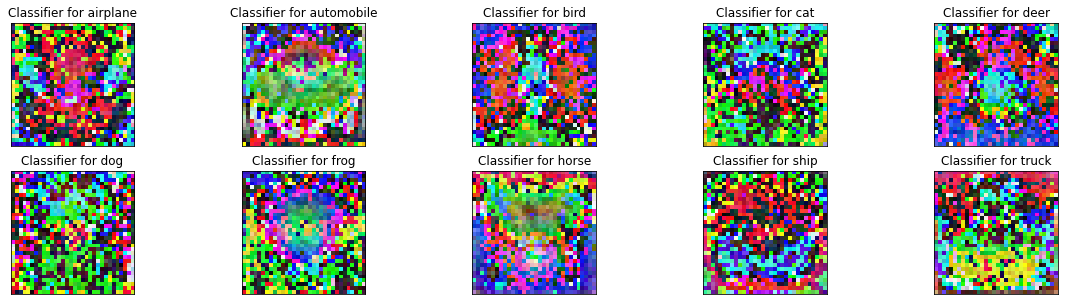

In [49]:
y_hat_test = forward_prop_linear(x_test,weights_linear)
print("Learning rate:", learning_rate_linear)
print("Training set final mean loss:", history_linear[-1])
print("Test set mean loss:",mean_sum_of_squared_errors(y_test, y_hat_test))
print("Accuracy for test set:", get_accuracy(y_hat_test, y_test),"%\n")

norm_W_linear = (weights_linear[0]+weights_linear[0].min())*\
                  (255/weights_linear[0].max())
norm_W_linear = norm_W_linear.reshape((32,32,3,K)).astype(np.uint8)

fig,ax = plt.subplots(2,5, figsize=(20,5), sharex=True, sharey=True)
for i in range(10):
  ax[i//5,i%5].set_title("Classifier for " + class_labels[i])
  ax[i//5,i%5].imshow(norm_W[:,:,:,i])
  ax[i//5,i%5].set_xticks([]),ax[i//5,i%5].set_yticks([])
plt.savefig("linear_masks.png")
plt.show()

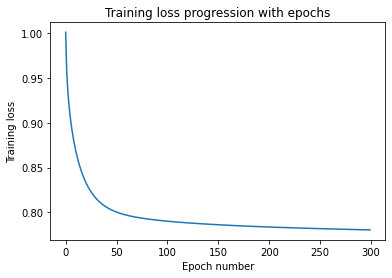

In [51]:
plt.plot(history)
plt.title("Training loss progression with epochs")
plt.xlabel("Epoch number"), plt.ylabel("Training loss")
plt.savefig("linear_training_loss.png")
plt.show()

# Part 2: 2-layer neural network

In [80]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def sigmoidPrime(z):
  return -(np.multiply(sigmoid(z),sigmoid(z)))

def initialize_2_layer_nn(shape, epsilon=0.001):
  W1 = np.random.randn(shape[0], shape[1])*epsilon
  b1 = np.zeros((1,shape[1]))
  W2 = np.random.randn(shape[1], shape[2])*epsilon
  b2 = np.zeros((1,shape[2]))
  return [W1.astype(np.float64),b1.astype(np.float64),W2.astype(np.float64),
          b2.astype(np.float64)]

def forward_prop_2_layer_nn(x_data, weights):
  z1 = np.matmul(x_data, weights[0]) + weights[1]
  a1 = sigmoid(z1)
  z2 = np.matmul(a1, weights[2]) + weights[3]
  return [z1,a1,z2]

def back_prop_2_layer_nn(y, xs, weights):
  dz2 = 2*(xs[-1]-y)/y.shape[0]
  db2 = np.sum(dz2,axis=0,keepdims=True)
  dW2 = np.sum(np.matmul(xs[-2].T,dz2),axis=0,keepdims=True)
  dz1 = sigmoidPrime(np.matmul(dz2,weights[2].T))
  db1 = np.sum(dz1,axis=0,keepdims=True)
  dW1 = np.sum(np.matmul(xs[0].T, dz1),axis=0,keepdims=True)
  return [dW1,db1,dW2,db2]

def gradient_descent_2_layer_nn(grads, weights, learning_rate=0.01):
  weights[0] = weights[0]-learning_rate*grads[0]
  weights[1] = weights[1]-learning_rate*grads[1]
  weights[2] = weights[2]-learning_rate*grads[2]
  weights[3] = weights[3]-learning_rate*grads[3]
  return weights

In [87]:
no_epochs = 300
H = 200
weights_nn = initialize_2_layer_nn((x_train.shape[1],H,K))
history_nn = []
learning_rate_nn = 0.00001

tik = time.time()

print("Starting training of 2-layer Neural Network for", no_epochs, "epochs")
for epo in range(1,no_epochs+1):
  results = forward_prop_2_layer_nn(x_train,weights_nn)
  y_hat = results[-1]
  loss = mean_sum_of_squared_errors(y_train, y_hat)
  grads = back_prop_2_layer_nn(y_train, [x_train]+results, weights_nn)
  weights = gradient_descent_2_layer_nn(grads, weights_nn, learning_rate_nn)
  history_nn.append(loss)
  if not(epo%20): print("Epoch no.", epo, "| Training loss:",loss)

tok = time.time()
etime = tok-tik
print("Training complete.",int(etime//60),"minutes and", int(etime%60),
      "seconds elapsed.")

Starting training of 2-layer Neural Network for 300 epochs


KeyboardInterrupt: ignored

# Part 3: Stochastic gradient descent

# Part 4: CNN